In [1]:
# Install Packages

# for path handling
import pathlib

# for loading images into numpy
import imageio

import numpy as np
import pandas as pd

# for greyscale conversion
from skimage.color import rgb2gray

# for plotting
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.image as tf_image


# Reading Data and Data Preparation

https://www.tensorflow.org/tutorials/load_data/images

In [2]:
# get image resolution
def get_image_resolution(image_path):
    image = imageio.imread(image_path)
    return image.shape


In [3]:
# check resolution of image
images = list(pathlib.Path("./images/training/fully/").glob("*.jpeg"))
image_resolution = get_image_resolution(images[0])

print(f"Image resolution: {image_resolution}")
# because they are thumbnails all images have the same resolution

Image resolution: (229, 400, 3)


In [6]:
# loading data with keras utility

path_to_data = "./images/training"

batch_size = 32
# get image dimensions
img_height, img_width = image_resolution[:2]

train_data: tf.data.Dataset = keras.utils.image_dataset_from_directory(
    path_to_data,
    labels="inferred",
    seed=1,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    validation_split=0.2,
    subset="training"
)

validation_data: tf.data.Dataset = keras.utils.image_dataset_from_directory(
    path_to_data,
    labels='inferred',
    seed=1,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    validation_split=0.2,
    subset="validation"
)

# check if data was read correctly
class_names = train_data.class_names
print(f"Class names: {class_names}")


Found 275 files belonging to 2 classes.
Using 220 files for training.
Found 275 files belonging to 2 classes.
Using 55 files for validation.
Class names: ['fully', 'hardtail']


# Dataexploration

Imageshape: (229, 400, 3) Labels: 0
Imageshape: (229, 400, 3) Labels: 0
Imageshape: (229, 400, 3) Labels: 1
Imageshape: (229, 400, 3) Labels: 0
Imageshape: (229, 400, 3) Labels: 0
Imageshape: (229, 400, 3) Labels: 1
Imageshape: (229, 400, 3) Labels: 1
Imageshape: (229, 400, 3) Labels: 0
Imageshape: (229, 400, 3) Labels: 0


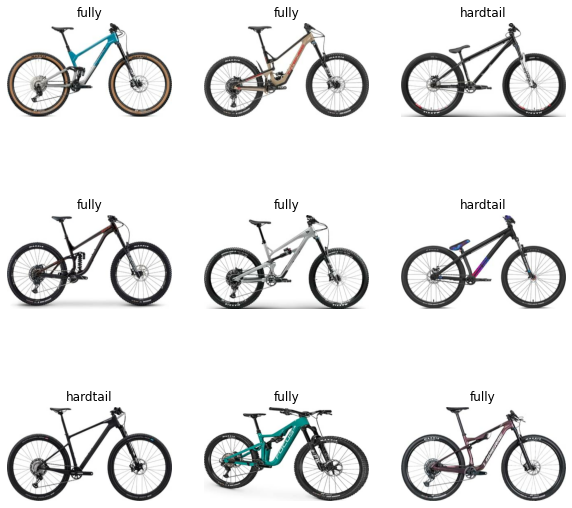

In [46]:
# plot some images
plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
    for i in range(9):
        print(f"Imageshape: {images[i].shape} Labels: {labels[i]}")
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")


In [50]:
# print dimmensions
# 32 => batch of 32 images
# 229 => height of image
# 400 => width of image
# 3 => RGB
for image_batch, labels_batch in train_data:
  print(f"Image Batch: {image_batch.shape},  Labels Batch: {labels_batch}")


Image Batch: (32, 229, 400, 3),  Labels Batch: [1 1 0 1 1 1 0 1 1 1 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 1 1]
Image Batch: (32, 229, 400, 3),  Labels Batch: [1 1 1 1 1 1 0 1 1 0 0 1 1 1 1 0 0 0 0 1 1 0 0 0 0 1 1 1 1 0 1 1]
Image Batch: (32, 229, 400, 3),  Labels Batch: [0 0 0 1 0 1 0 1 0 0 1 1 1 0 1 1 1 1 0 1 0 1 1 0 0 1 1 1 0 0 1 1]
Image Batch: (32, 229, 400, 3),  Labels Batch: [0 0 1 0 1 1 0 0 1 1 1 1 1 1 1 0 1 1 1 0 0 1 0 0 0 1 0 1 1 0 0 1]
Image Batch: (32, 229, 400, 3),  Labels Batch: [1 1 0 0 1 0 0 1 1 0 1 1 1 1 0 1 0 1 1 1 0 0 0 0 1 0 1 0 0 1 0 0]
Image Batch: (32, 229, 400, 3),  Labels Batch: [1 1 0 0 1 0 1 1 1 0 1 1 1 0 1 1 0 0 0 0 0 0 0 0 1 1 1 1 0 0 1 0]
Image Batch: (28, 229, 400, 3),  Labels Batch: [0 1 1 1 0 0 1 0 1 0 1 0 0 0 1 0 0 0 0 0 0 1 1 1 1 1 1 1]


# Dataprepatation

In [51]:
# normalization
normalization_layer = keras.layers.experimental.preprocessing.Rescaling(1./255)

In [52]:
# greyscale conversion
greyscale_layer = keras.layers.Lambda(rgb2gray)

In [186]:
data_preparation_layer = keras.Sequential([
    # greyscale_layer,
    normalization_layer,
], "Data_Preparation")


In [187]:
# data augmentation
data_augmentation_layer = keras.Sequential([
    # flip random bikes left to right, so the AI will be able to process bikes facing in any direction
    keras.layers.RandomFlip("horizontal", seed=1)
], "Data_Augmentation")


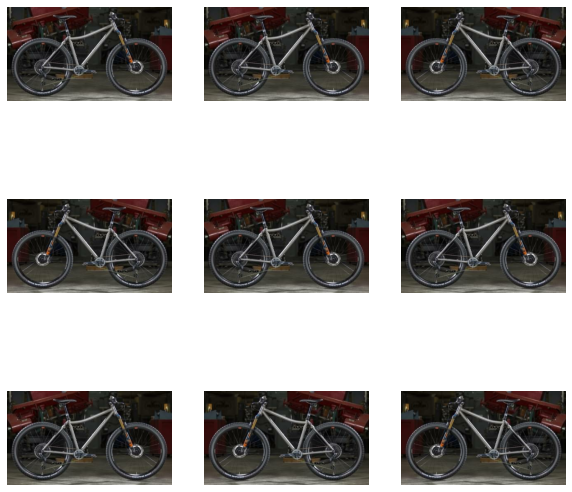

In [188]:
# visualize data augmentation
plt.figure(figsize=(10, 10))
for images, _ in train_data.take(1):
  for i in range(9):
    augmented_images = data_augmentation_layer(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")


In [53]:
# Performace tweaks

train_data = train_data.cache().prefetch(
    buffer_size=tf.data.experimental.AUTOTUNE)
validation_data = validation_data.cache().prefetch(
    buffer_size=tf.data.experimental.AUTOTUNE)


In [189]:
num_classes = len(class_names)

model = keras.Sequential([
    # Data preparation
    data_preparation_layer,

    # Data augmentation
    data_augmentation_layer,

    # Convolutional layers
    keras.layers.Conv2D(32, 3, activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(32, 3, activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(32, 3, activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(num_classes)
])

model.compile(
    optimizer="adam",
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)


In [183]:
epochs = 5

In [184]:
print(f"Num CPUs available: {len(tf.config.list_physical_devices('CPU'))}")
print(f"Num GPUs available: {len(tf.config.list_physical_devices('GPU'))}")
# cannot use gpu as I am using ubuntu subsystem in WSL

Num CPUs available: 1
Num GPUs available: 0


In [190]:
# train model
history = model.fit(
    train_data,
    validation_data=validation_data,
    epochs=epochs
)


Epoch 1/5
7/7 [==============================] - 17s 2s/step - loss: 1.5190 - accuracy: 0.4545 - val_loss: 0.6407 - val_accuracy: 0.8364
Epoch 2/5
7/7 [==============================] - 17s 2s/step - loss: 0.6355 - accuracy: 0.6636 - val_loss: 0.5197 - val_accuracy: 0.8727
Epoch 3/5
7/7 [==============================] - 17s 2s/step - loss: 0.4767 - accuracy: 0.8455 - val_loss: 0.3342 - val_accuracy: 0.8727
Epoch 4/5
7/7 [==============================] - 16s 2s/step - loss: 0.3271 - accuracy: 0.8455 - val_loss: 0.2087 - val_accuracy: 0.9273
Epoch 5/5
7/7 [==============================] - 15s 2s/step - loss: 0.2688 - accuracy: 0.8864 - val_loss: 0.1735 - val_accuracy: 0.9455


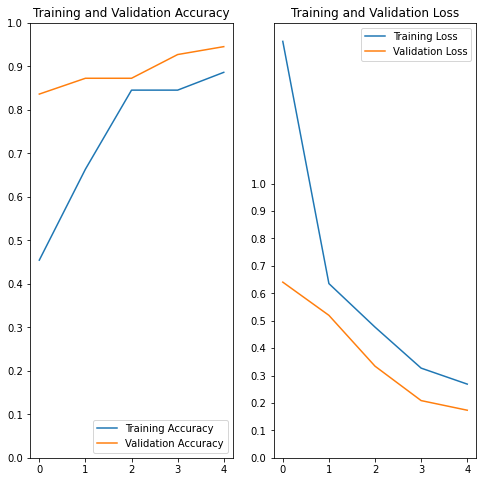

In [191]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.yticks(np.arange(0, 1.1, 0.1))
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.yticks(np.arange(0, 1.1, 0.1))
plt.title('Training and Validation Loss')
plt.show()


In [145]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 229, 400, 3)       0         
_________________________________________________________________
sequential_4 (Sequential)    (None, 229, 400, 3)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 227, 398, 32)      896       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 113, 199, 32)      0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 111, 197, 32)      9248      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 55, 98, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 53, 96, 32)       

In [192]:
# evaluation
# TRAIN
for image_batch, labels_batch in train_data.take(1):
    train_loss, train_acc = model.evaluate(
        image_batch, labels_batch, verbose=2)
    print(
        f"TRAIN: Loss: {round(train_loss,3)},  Accuracy: {round(train_acc,2)}")


# VALIDATION
for image_batch, labels_batch in validation_data.take(1):
    validation_loss, validation_acc = model.evaluate(
        image_batch, labels_batch, verbose=2)
    print(
        f"VALIDATION: Loss: {round(validation_loss,3)},  Accuracy: {round(validation_acc,2)}")


1/1 - 0s - loss: 0.2102 - accuracy: 0.9375
TRAIN: Loss: 0.21,  Accuracy: 0.94
1/1 - 0s - loss: 0.1839 - accuracy: 0.9375
VALIDATION: Loss: 0.184,  Accuracy: 0.94


# Predicting new Data

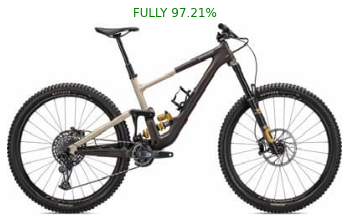

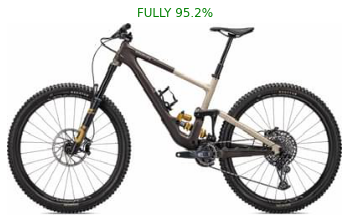

In [239]:
def predict_image(image_path, mirrored=False):
    img = keras.utils.load_img(image_path, target_size=(img_height, img_width))

    if mirrored == True:
        img = tf.image.flip_left_right(img)

    img_array = keras.utils.img_to_array(img)
    # create a batch of size 1
    img_array = tf.expand_dims(img_array, axis=0)

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])

    plt.imshow(img)
    plt.axis("off")

    color = ""

    probability = round(100*np.max(score), 2)

    if probability > 80:
        color = "green"
    elif probability > 60:
        color = "orange"
    else:
        color = "red"

    plt.title(
        f"{class_names[np.argmax(score)].upper()} {probability}%", color=color)
    plt.show()
    return predictions


paths_to_test_images = list(pathlib.Path("./images/test/").glob("*.jpeg"))

rnd_image = np.random.choice(paths_to_test_images)

predict_image(rnd_image);
predict_image(rnd_image, mirrored=True);


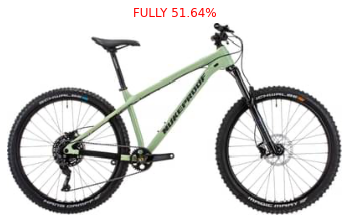

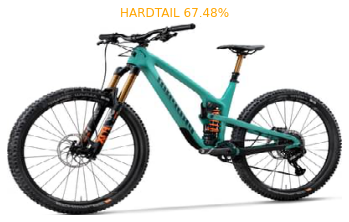

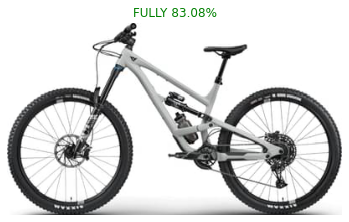

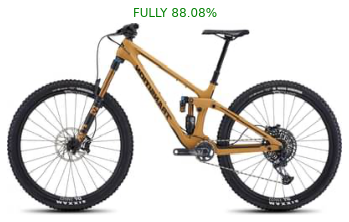

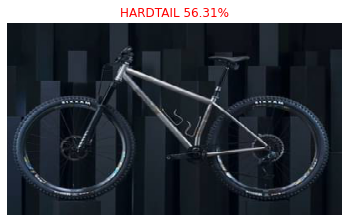

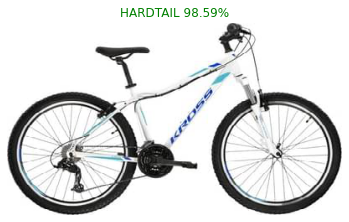

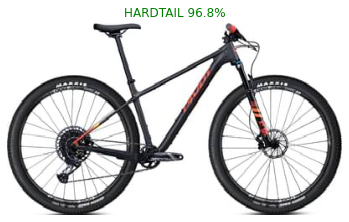

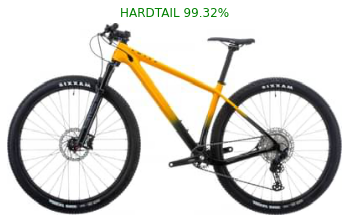

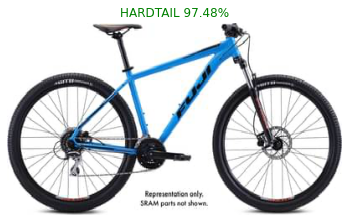

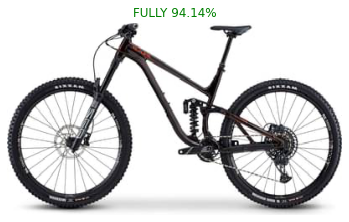

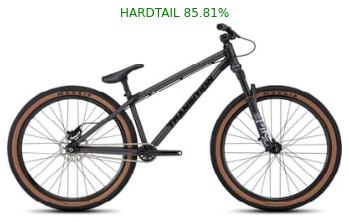

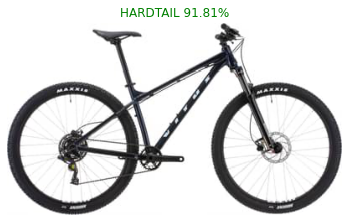

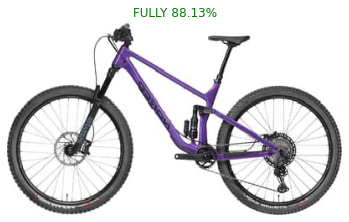

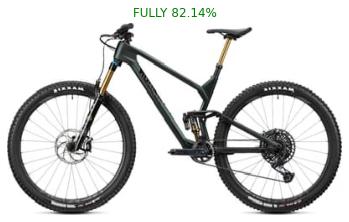

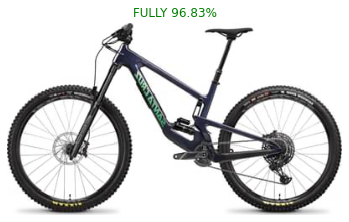

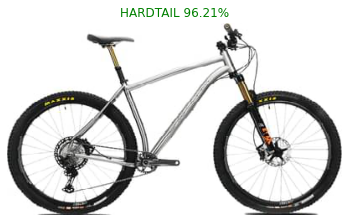

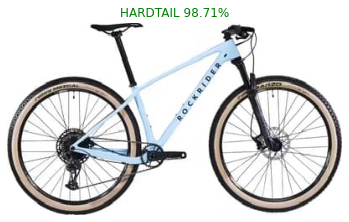

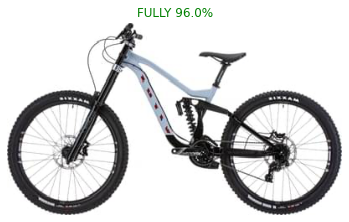

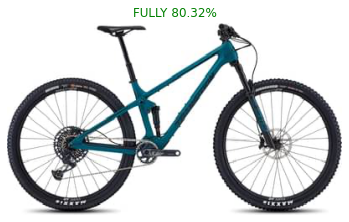

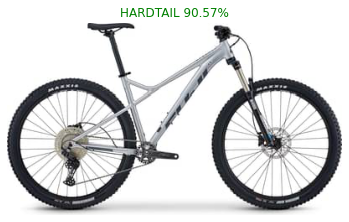

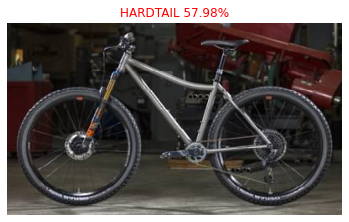

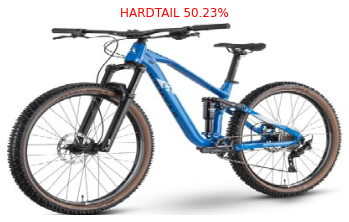

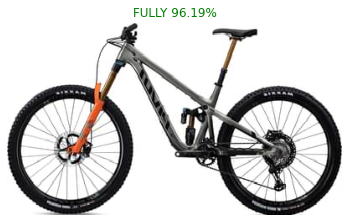

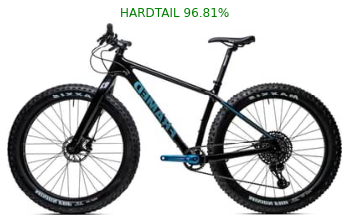

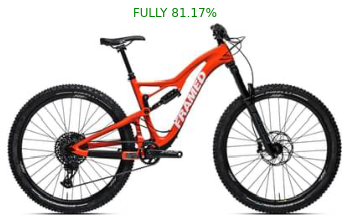

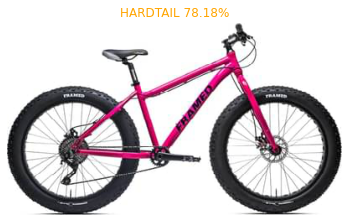

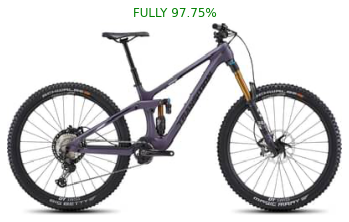

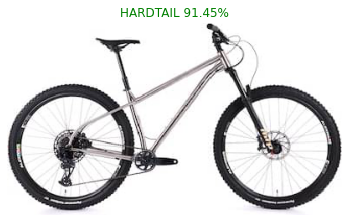

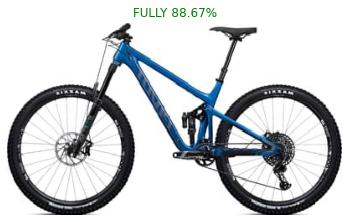

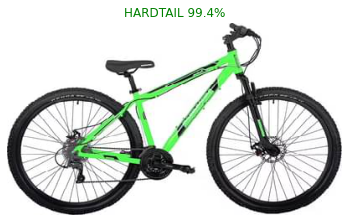

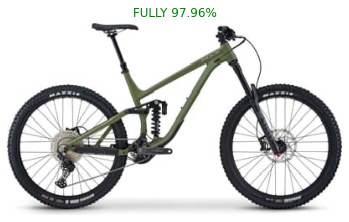

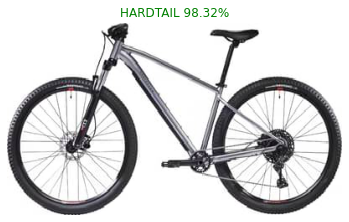

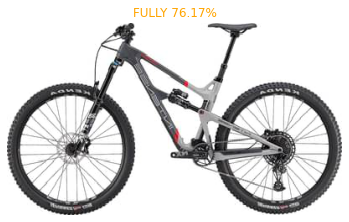

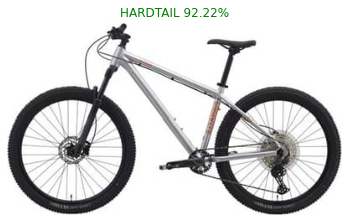

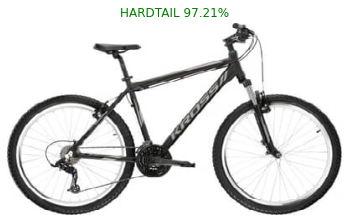

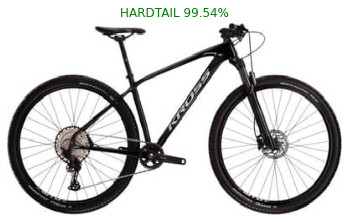

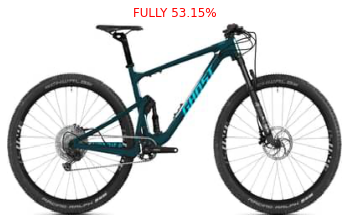

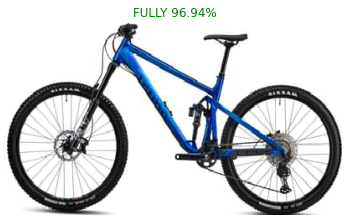

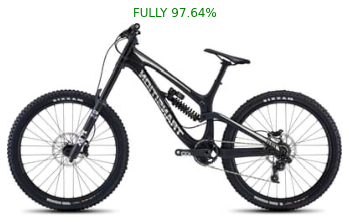

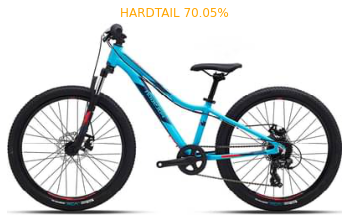

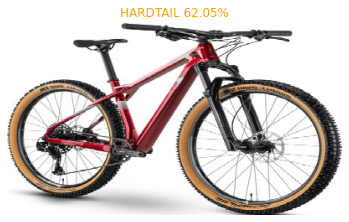

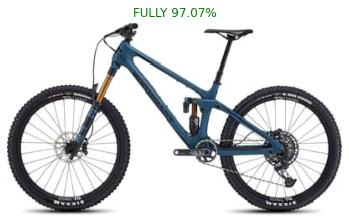

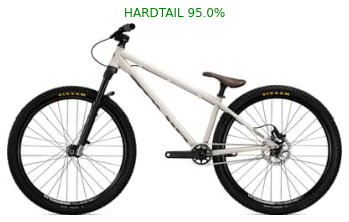

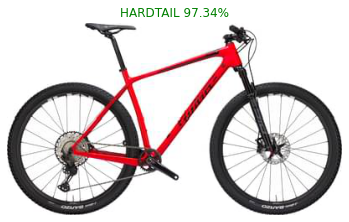

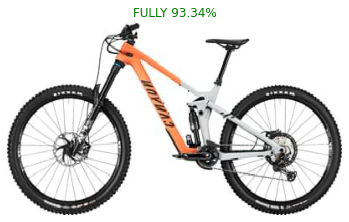

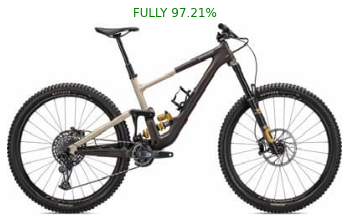

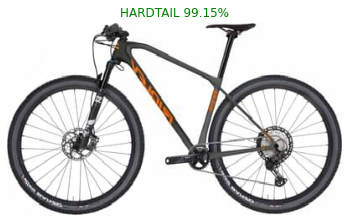

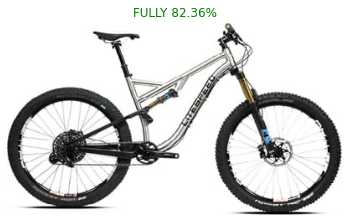

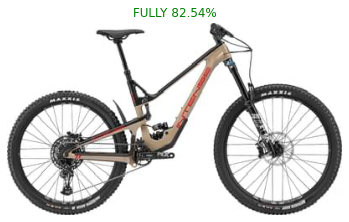

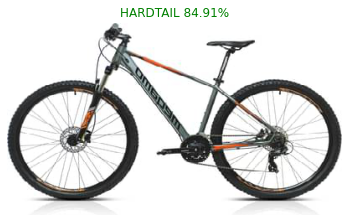

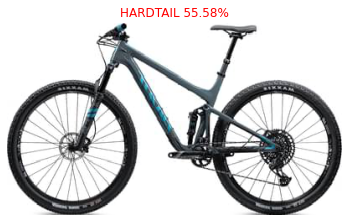

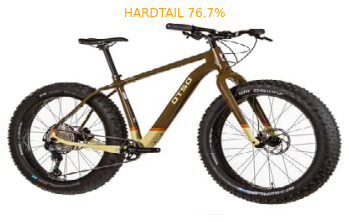

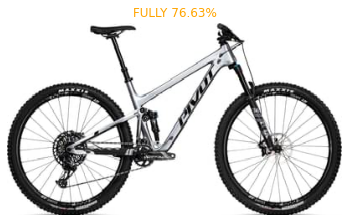

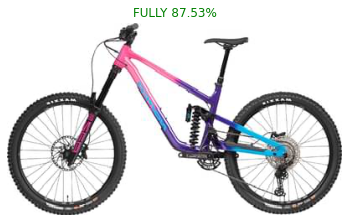

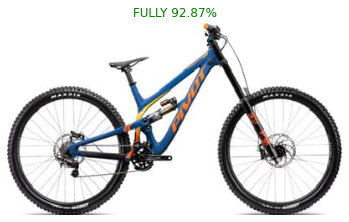

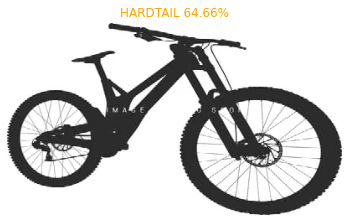

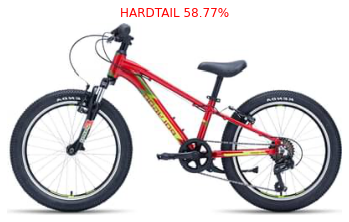

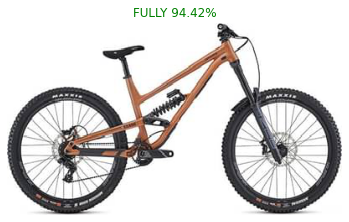

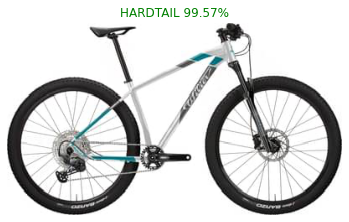

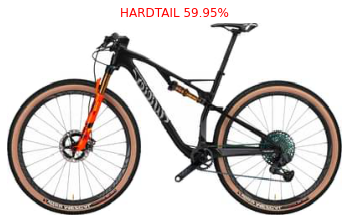

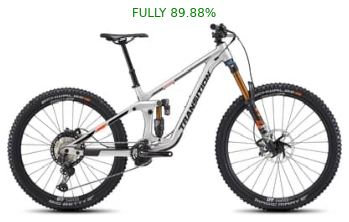

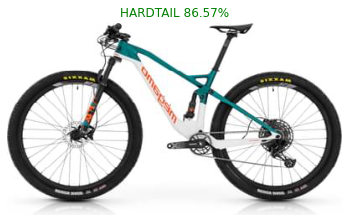

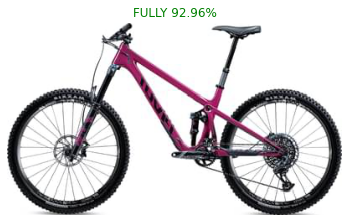

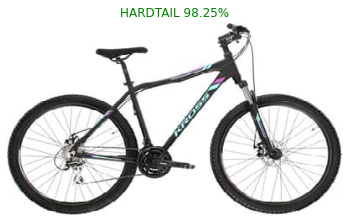

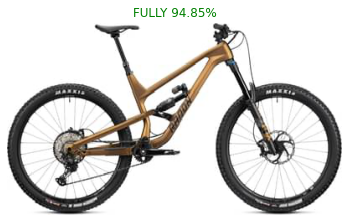

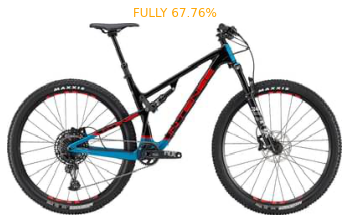

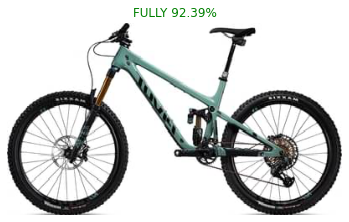

In [228]:
# predict all test images
for image_path in paths_to_test_images:
    predict_image(image_path)

In [67]:
def plot_image(i, predictions_array, true_label, img):
  true_label, img = true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)


def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(2))
  plt.yticks([])
  thisplot = plt.bar(range(2), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')


In [69]:
# predict

test_data = keras.utils.image_dataset_from_directory(
    "./images/test",
    labels="none",
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

pred = []
for image_batch in test_data:
    prediction = model.predict(image_batch)
    pred = prediction
    break


ValueError: `labels` argument should be a list/tuple of integer labels, of the same size as the number of image files in the target directory. If you wish to infer the labels from the subdirectory names in the target directory, pass `labels="inferred"`. If you wish to get a dataset that only contains images (no labels), pass `label_mode=None`.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


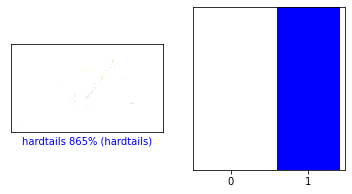

In [41]:
for test_images, test_labels in validation_data:
    i = 0
    plt.figure(figsize=(6, 3))
    plt.subplot(1, 2, 1)
    plot_image(i, pred[i], test_labels, test_images)
    plt.subplot(1, 2, 2)
    plot_value_array(i, pred[i],  test_labels)
    plt.show()
    break
